## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.regularizers import l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio = 1e-4, drp_ratio=0.2,
              L2_activate=False, BN_activate=False, Dropout_activate=False):
    l2_ratio = 0 if L2_activate == False else None
    
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, 
                      activation='relu', 
                      name='hidden_layer%d'%(i+1), 
                      kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x) if Dropout_activate == True else x
            x = BatchNormalization()(x) if BN_activate == True else x
            
        else:
            x = Dense(units=n_units, 
                      activation='relu', 
                      name='hidden_layer%d'%(i+1),
                      kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(drp_ratio)(x) if Dropout_activate == True else x
            x = BatchNormalization()(x) if BN_activate == True else x
    
    output_layer = Dense(units=output_units, activation='softmax', name='output_layer')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    return model

In [6]:
# Hyperparams
LEARNING_RATE = 1e-4
EPOCHS = 50
BATCH_SIZE = 512
L2 = [False, True]
dropout = [False, True]
BN = [False, True]

In [7]:
for i in itertools.product(L2, dropout, BN):
    print(i)

(False, False, False)
(False, False, True)
(False, True, False)
(False, True, True)
(True, False, False)
(True, False, True)
(True, True, False)
(True, True, True)


In [8]:
results = {}
for i, (l2_iter, drop, bn) in enumerate(itertools.product(L2, dropout, BN)):
    keras.backend.clear_session()
    print('Experiment with L2 = %s, dropout = %s, BN = %s'%(l2_iter, drop, bn))
    
    model = build_mlp(input_shape=x_train.shape[1:], L2_activate=l2_iter, Dropout_activate=drop, BN_activate=bn)
    model.summary()
    
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    model.fit(x_train, y_train,
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             validation_data=(x_test, y_test),
             shuffle=True)
    
    exp_name_tag = 'L2-%s-Dropout-%s-BN-%s'%(l2_iter, drop, bn)
    results[exp_name_tag] = {'train_loss': model.history.history['loss'],
                            'valid_loss': model.history.history['val_loss'],
                            'train_acc': model.history.history['accuracy'],
                            'valid_acc': model.history.history['val_accuracy']}

Experiment with L2 = False, dropout = False, BN = False
Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_____________________________________________________

50000/50000 [==============================] - 35s 696us/step - loss: 0.9940 - accuracy: 0.6573 - val_loss: 1.3064 - val_accuracy: 0.5377
Epoch 45/50
50000/50000 [==============================] - 35s 705us/step - loss: 0.9830 - accuracy: 0.6619 - val_loss: 1.3279 - val_accuracy: 0.5364
Epoch 46/50
50000/50000 [==============================] - 36s 713us/step - loss: 0.9774 - accuracy: 0.6628 - val_loss: 1.3138 - val_accuracy: 0.5458
Epoch 47/50
50000/50000 [==============================] - 35s 700us/step - loss: 0.9665 - accuracy: 0.6671 - val_loss: 1.3090 - val_accuracy: 0.5407
Epoch 48/50
50000/50000 [==============================] - 35s 690us/step - loss: 0.9617 - accuracy: 0.6705 - val_loss: 1.3172 - val_accuracy: 0.5364
Epoch 49/50
50000/50000 [==============================] - 34s 686us/step - loss: 0.9518 - accuracy: 0.6737 - val_loss: 1.3469 - val_accuracy: 0.5307
Epoch 50/50
50000/50000 [==============================] - 35s 692us/step - loss: 0.9466 - accuracy: 0.6737 - va

50000/50000 [==============================] - 37s 746us/step - loss: 0.3466 - accuracy: 0.9087 - val_loss: 1.8965 - val_accuracy: 0.4796
Epoch 39/50
50000/50000 [==============================] - 37s 740us/step - loss: 0.3319 - accuracy: 0.9149 - val_loss: 1.8971 - val_accuracy: 0.4750
Epoch 40/50
50000/50000 [==============================] - 37s 738us/step - loss: 0.3195 - accuracy: 0.9183 - val_loss: 2.2820 - val_accuracy: 0.4256
Epoch 41/50
50000/50000 [==============================] - 38s 753us/step - loss: 0.3011 - accuracy: 0.9251 - val_loss: 2.0276 - val_accuracy: 0.4533
Epoch 42/50
50000/50000 [==============================] - 38s 754us/step - loss: 0.2841 - accuracy: 0.9308 - val_loss: 2.0201 - val_accuracy: 0.4630
Epoch 43/50
50000/50000 [==============================] - 37s 736us/step - loss: 0.2709 - accuracy: 0.9348 - val_loss: 1.9703 - val_accuracy: 0.4795
Epoch 44/50
50000/50000 [==============================] - 38s 754us/step - loss: 0.2547 - accuracy: 0.9395 - va

50000/50000 [==============================] - 36s 725us/step - loss: 1.3152 - accuracy: 0.5343 - val_loss: 1.3385 - val_accuracy: 0.5251
Epoch 33/50
50000/50000 [==============================] - 36s 720us/step - loss: 1.3126 - accuracy: 0.5366 - val_loss: 1.3199 - val_accuracy: 0.5342
Epoch 34/50
50000/50000 [==============================] - 36s 729us/step - loss: 1.2992 - accuracy: 0.5402 - val_loss: 1.3273 - val_accuracy: 0.5280
Epoch 35/50
50000/50000 [==============================] - 37s 742us/step - loss: 1.2869 - accuracy: 0.5453 - val_loss: 1.3163 - val_accuracy: 0.5287
Epoch 36/50
50000/50000 [==============================] - 36s 719us/step - loss: 1.2836 - accuracy: 0.5466 - val_loss: 1.3330 - val_accuracy: 0.5287
Epoch 37/50
50000/50000 [==============================] - 37s 732us/step - loss: 1.2722 - accuracy: 0.5495 - val_loss: 1.3209 - val_accuracy: 0.5322
Epoch 38/50
50000/50000 [==============================] - 37s 731us/step - loss: 1.2637 - accuracy: 0.5535 - va

Epoch 24/50
50000/50000 [==============================] - 40s 796us/step - loss: 1.4109 - accuracy: 0.4966 - val_loss: 1.4627 - val_accuracy: 0.4737
Epoch 25/50
50000/50000 [==============================] - 41s 827us/step - loss: 1.3985 - accuracy: 0.4991 - val_loss: 1.4114 - val_accuracy: 0.4928
Epoch 26/50
50000/50000 [==============================] - 38s 768us/step - loss: 1.3855 - accuracy: 0.5041 - val_loss: 1.4062 - val_accuracy: 0.4944
Epoch 27/50
50000/50000 [==============================] - 39s 780us/step - loss: 1.3781 - accuracy: 0.5076 - val_loss: 1.3964 - val_accuracy: 0.5046
Epoch 28/50
50000/50000 [==============================] - 39s 775us/step - loss: 1.3706 - accuracy: 0.5089 - val_loss: 1.4144 - val_accuracy: 0.4971
Epoch 29/50
50000/50000 [==============================] - 38s 769us/step - loss: 1.3607 - accuracy: 0.5114 - val_loss: 1.4181 - val_accuracy: 0.4911
Epoch 30/50
50000/50000 [==============================] - 39s 773us/step - loss: 1.3564 - accuracy:

50000/50000 [==============================] - 37s 745us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 23/50
50000/50000 [==============================] - 36s 720us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 24/50
50000/50000 [==============================] - 36s 718us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 25/50
50000/50000 [==============================] - 36s 726us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 26/50
50000/50000 [==============================] - 36s 714us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 27/50
50000/50000 [==============================] - 36s 724us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 28/50
50000/50000 [==============================] - 36s 713us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoc

50000/50000 [==============================] - 38s 767us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 19/50
50000/50000 [==============================] - 38s 767us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 20/50
50000/50000 [==============================] - 40s 804us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 21/50
50000/50000 [==============================] - 38s 763us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 22/50
50000/50000 [==============================] - 38s 764us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 23/50
50000/50000 [==============================] - 39s 775us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 24/50
50000/50000 [==============================] - 38s 760us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoc

50000/50000 [==============================] - 39s 790us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 15/50
50000/50000 [==============================] - 38s 762us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 16/50
50000/50000 [==============================] - 39s 776us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 17/50
50000/50000 [==============================] - 38s 768us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 18/50
50000/50000 [==============================] - 37s 746us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 19/50
50000/50000 [==============================] - 39s 778us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 20/50
50000/50000 [==============================] - 38s 751us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoc

Epoch 8/50
50000/50000 [==============================] - 41s 826us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 9/50
50000/50000 [==============================] - 40s 798us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 10/50
50000/50000 [==============================] - 40s 796us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 11/50
50000/50000 [==============================] - 40s 793us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 12/50
50000/50000 [==============================] - 41s 827us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 13/50
50000/50000 [==============================] - 41s 816us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 14/50
50000/50000 [==============================] - 40s 802us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0

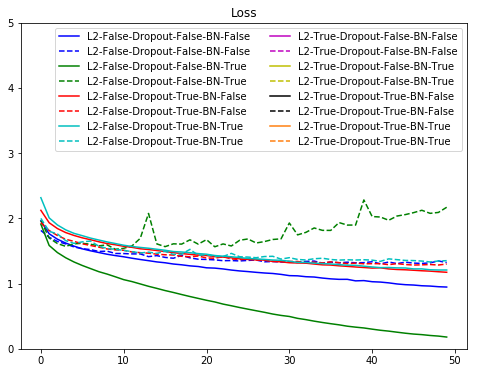

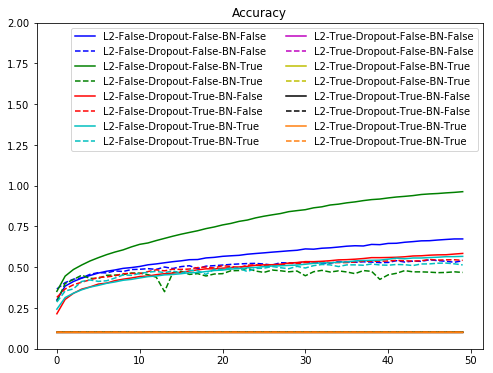

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'C1']

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])), results[cond]['train_loss'], '-', color=color_bar[i], label=cond)
    plt.plot(range(len(results[cond]['valid_loss'])), results[cond]['valid_loss'], '--', color=color_bar[i], label=cond)
plt.title('Loss')
plt.ylim(0,5)
plt.legend(ncol=2)
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])), results[cond]['train_acc'], '-', color=color_bar[i], label=cond)
    plt.plot(range(len(results[cond]['valid_acc'])), results[cond]['valid_acc'], '--', color=color_bar[i], label=cond)
plt.title('Accuracy')
plt.ylim(0,2)
plt.legend(ncol=2)
plt.show()